**Deterministic shock solution of Boltzmann equation with 3D velocity formulation**

In [1]:
using Revise, Kinetic, Plots, OffsetArrays, ProgressMeter, OrdinaryDiffEq

In [2]:
case = "shock"
space = "1d1f3v"
nSpecies = 1
interpOrder = 1
limiter = "vanleer"
cfl = 0.7
maxTime = 250.0
x0 = -35.0
x1 = 35.0
nx = 50
pMeshType = "uniform"
nxg = 1
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vmin = -10.0
vmax = 10.0
nv = 24
nvg = 0
wmin = -10.0
wmax = 10.0
nw = 24
nwg = 0
vMeshType = "rectangle"
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
nm = 5
tLen = 3
nh = 12;

In [3]:
γ = heat_capacity_ratio(inK, 1)
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType)
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)
wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR = ib_rh(mach, γ, vSpace.u, inK)
ib = IB2F(wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR)
ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd())

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen)

0.0f0:0.0399324f0:0.0798648f0

In [4]:
γ = heat_capacity_ratio(inK, 3)
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType)
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType);

In [5]:
primL = [1.0, mach * sqrt(γ / 2.0), 0., 0., 1.0]

MaR = sqrt((mach^2 * (γ - 1.0) + 2.0) / (2.0 * γ * mach^2 - (γ - 1.0)))
ratioT =
    (1.0 + (γ - 1.0) / 2.0 * mach^2) * (2.0 * γ / (γ - 1.0) * mach^2 - 1.0) /
    (mach^2 * (2.0 * γ / (γ - 1.0) + (γ - 1.0) / 2.0))

primR = [
    primL[1] * (γ + 1.0) * mach^2 / ((γ - 1.0) * mach^2 + 2.0),
    MaR * sqrt(γ / 2.0) * sqrt(ratioT),
    0.,
    0.,
    primL[end] / ratioT,
]

wL = prim_conserve(primL, γ)
wR = prim_conserve(primR, γ)

fL = maxwellian(vSpace3D.u, vSpace3D.v, vSpace3D.w, primL)
fR = maxwellian(vSpace3D.u, vSpace3D.v, vSpace3D.w, primR)

bcL = deepcopy(primL)
bcR = deepcopy(primR);

In [6]:
ib = IB1F(wL, primL, fL, bcL, wR, primR, fR, bcR)
ks = SolverSet(set, pSpace, vSpace3D, gas, ib, pwd());

In [7]:
kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen)

0.0f0:0.043301642f0:0.086603284f0

In [10]:
phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    alphaRef,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    boltzmann_fft(f[1:end,1:end,1:end], Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

boltzmann! (generic function with 1 method)

In [11]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D1F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.fL),
        )
    else
        ctr[i] = ControlVolume1D1F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.fR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.wL, ks.ib.fL)
end

In [15]:
function step!(
    fwL::Array{<:AbstractFloat,1},
    ffL::AbstractArray{<:AbstractFloat,3},
    w::Array{<:AbstractFloat,1},
    prim::Array{<:AbstractFloat,1},
    f::AbstractArray{<:AbstractFloat,3},
    fwR::Array{<:AbstractFloat,1},
    ffR::AbstractArray{<:AbstractFloat,3},
    γ::Real,
    uVelo::AbstractArray{<:AbstractFloat,3},
    vVelo::AbstractArray{<:AbstractFloat,3},
    wVelo::AbstractArray{<:AbstractFloat,3},
    μᵣ::Real,
    ω::Real,
    dx::Real,
    dt::Real,
    RES::Array{<:AbstractFloat,1},
    AVG::Array{<:AbstractFloat,1},
)

    #--- store W^n and calculate H^n,\tau^n ---#
    w_old = deepcopy(w)

    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    #--- record residuals ---#
    @. RES += (w - w_old)^2
    @. AVG += abs(w)

    # Boltzmann
    df = boltzmann(f, [kn_bzm, nm, phi, psi, phipsi], tspan)
    @. f += df * dt
    
    #prob = ODEProblem(boltzmann!, f[1:end,1:end,1:end], tspan, [kn_bzm, nm, phi, psi, phipsi])
    #prob = ODEProblem(boltzmann!, f, tspan, [kn_bzm, nm, phi, psi, phipsi])
    #f .= Array(solve(prob, Midpoint(), saveat=tran))[:,:,:,end]
    
    # BGK
    #M = maxwellian(uVelo, vVelo, wVelo, prim)
    #τ = vhs_collision_time(prim, μᵣ, ω)

    for k in axes(wVelo, 3), j in axes(vVelo, 2), i in axes(uVelo, 1)
        f[i, j, k] += (ffL[i, j, k] - ffR[i, j, k]) / dx
    end

end

step! (generic function with 1 method)

In [16]:
function update!(
    KS::SolverSet,
    ctr::AbstractArray{<:AbstractControlVolume1D,1},
    face::Array{<:AbstractInterface1D,1},
    dt::Real,
    residual::Array{<:AbstractFloat,1},
)

    sumRes = zeros(axes(KS.ib.wL))
    sumAvg = zeros(axes(KS.ib.wL))

    for i = 2:KS.pSpace.nx-1
        @inbounds step!(
            face[i].fw,
            face[i].ff,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].f,
            face[i+1].fw,
            face[i+1].ff,
            KS.gas.γ,
            KS.vSpace.u,
            KS.vSpace.v,
            KS.vSpace.w,
            KS.gas.μᵣ,
            KS.gas.ω,
            ctr[i].dx,
            dt,
            sumRes,
            sumAvg,
        )
    end

    for i in eachindex(residual)
        residual[i] = sqrt(sumRes[i] * KS.pSpace.nx) / (sumAvg[i] + 1.e-7)
    end

end

update! (generic function with 1 method)

In [23]:
residual = Array{Float32}(undef, 5)

@showprogress for iter = 1:500
    Kinetic.evolve!(ks, ctr, face, dt)
    update!(ks, ctr, face, dt, residual)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:16


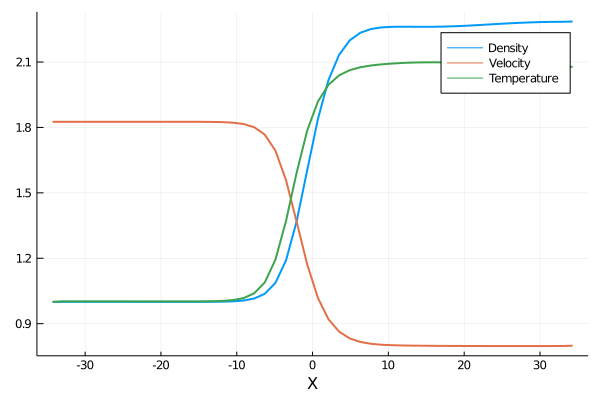

In [22]:
plot_line(ks, ctr)

In [ ]:
prob = ODEProblem(boltzmann!, ctr[25].f, tspan, [kn_bzm, nm, phi, psi, phipsi])
data_boltz = solve(prob, Tsit5(), saveat=tran) |> Array;

In [ ]:
data_boltz

In [ ]:
plot(vSpace3D.u[:,1,1], data_boltz[:,18,18,1])